In [1]:
import re

from math import floor
from pathlib import Path

import h5py
import lmfit as lm
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import mplstylize as scimpl
import seaborn as sns

%config InlineBackend.figure_format = 'retina'

In [2]:
slope_model = lm.models.LinearModel()
slope_params = slope_model.make_params(intercept=0, slope=0)

def remove_slope(df):
    slope_result = slope_model.fit(
        df.select(pl.col("signal").slice(0, 100)).get_columns(),
        x=df.select(pl.col("time").slice(0, 100)).get_columns(),
        params=slope_params,
    )
    s = pl.lit(slope_result.eval(x=df.get_column("time")))
    return df.with_columns((pl.col("signal") - s).alias("signal"))


voltage_eq = 921e-3  # V


def generate_frames(paths):
    for path in paths:
        with h5py.File(str(path), "r") as hdf5_file:
            time = 1e9 * np.array(hdf5_file["treal"]).squeeze()
            measurements = {
                str(i): np.asarray(
                    hdf5_file[hdf5_file["data"][i, 0]]["dev2434"]["outputpwas"]["wave"][
                        "x"
                    ]
                ).squeeze()
                for i in range(hdf5_file["data"].shape[0])
            }

            data = (
                pl.LazyFrame(measurements)
                .with_columns(
                    pl.lit(Path(path).stem).alias("filename"),
                    pl.lit(time).alias("time"),
                )
                .melt(
                    id_vars=["time", "filename"],
                    value_name="signal",
                    variable_name="scan_num",
                )
                .sort("time", "scan_num")
                .with_columns(
                    pl.col("scan_num").cast(pl.Int32),
                    (
                        (pl.col("signal") - pl.col("signal").slice(0, 10).mean())
                        / voltage_eq
                    ).over("scan_num"),
                )
            )

            data = data.group_by("scan_num", "filename").map_groups(
                remove_slope, schema=data.schema
            )  # Removal of linear background (detection artefact)

            data = (
                data.group_by("time", "filename")
                .agg(
                    pl.col("signal").mean().alias("signal"),
                    pl.col("signal").std().alias("std"),
                )
                .drop("scan_num")
                .sort("time")
            )  # Average over scans

            step_index = (
                data.select(
                    (
                        pl.col("signal").rolling_mean(3)
                        - pl.col("signal").shift(3).rolling_mean(3)
                    )
                    .arg_min()
                    .alias("step_index")
                )
                .collect()
                .item()
            )

            data = data.with_columns(
                (pl.col("time") - pl.col("time").get(step_index)).alias("time"),
                pl.col("signal"),
            )  # Shift time by step detection

            yield data


def verify(filename):
    correct_filetype = filename.suffix == ".mat"
    correct_data = "SRO" in filename.name
    return correct_filetype and correct_data


paths = [
    file
    for date in [
        "03.07.2023",
        "04.07.2023",
        "05.07.2023",
        "06.07.2023",
        "07.07.2023",
        "10.07.2023",
    ]
    for file in (Path("./Data") / date).iterdir()
    if verify(file)
]


def extract_temperature(set_label):
    regex_pattern = r"STAMP_(\d+|NoHeat)"
    result = re.search(regex_pattern, set_label).group(1)
    if result == "NoHeat":
        return 60.0
    return float(result)


def remove_thermal(df):
    time, waveform = df.select("time", "signal").get_columns()
    background_model = lm.models.StepModel(prefix="step_") * (
        lm.models.ExponentialModel(prefix="expfast_")
        + lm.models.ExponentialModel(prefix="expslow_")
    )
    background_params = background_model.make_params()
    params_dict = {
        "step_amplitude": {"value": 1, "vary": False},
        "step_center": {"value": 0.0, "min": -1e-1, "max": 1e-1, "vary": True},
        "step_sigma": {"value": 0.0, "min": 0.0, "max": 1.0, "vary": False},
        "expslow_amplitude": {"value": -1, "min": -1e1, "max": 0, "vary": True},
        "expslow_decay": {"value": 2, "min": 1, "max": 10.0},
        "expfast_amplitude": {"value": -1, "min": -1e1, "max": 0, "vary": True},
        "expfast_decay": {"value": 0.05},
    }
    for name, param in params_dict.items():
        background_params[name].set(**param)

    res = background_model.fit(waveform, background_params, x=time)

    return df.with_columns((pl.col("signal") - pl.lit(res.best_fit)).alias("residual"))


# Load data
data = pl.concat(generate_frames(paths)).sort("filename", "time")

# Parse filenames
data = data.with_columns(
    pl.col("filename").str.split("_").list.get(-5).alias("label"),
    pl.col("filename")
    .map_elements(extract_temperature, return_dtype=pl.Float32)
    .alias("temperature"),
)

# Remove thermal background
data = data.group_by("filename").map_groups(remove_thermal, schema=data.schema)

data = data.collect()

/Users/monochromatti/miniconda3/envs/scicomp/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


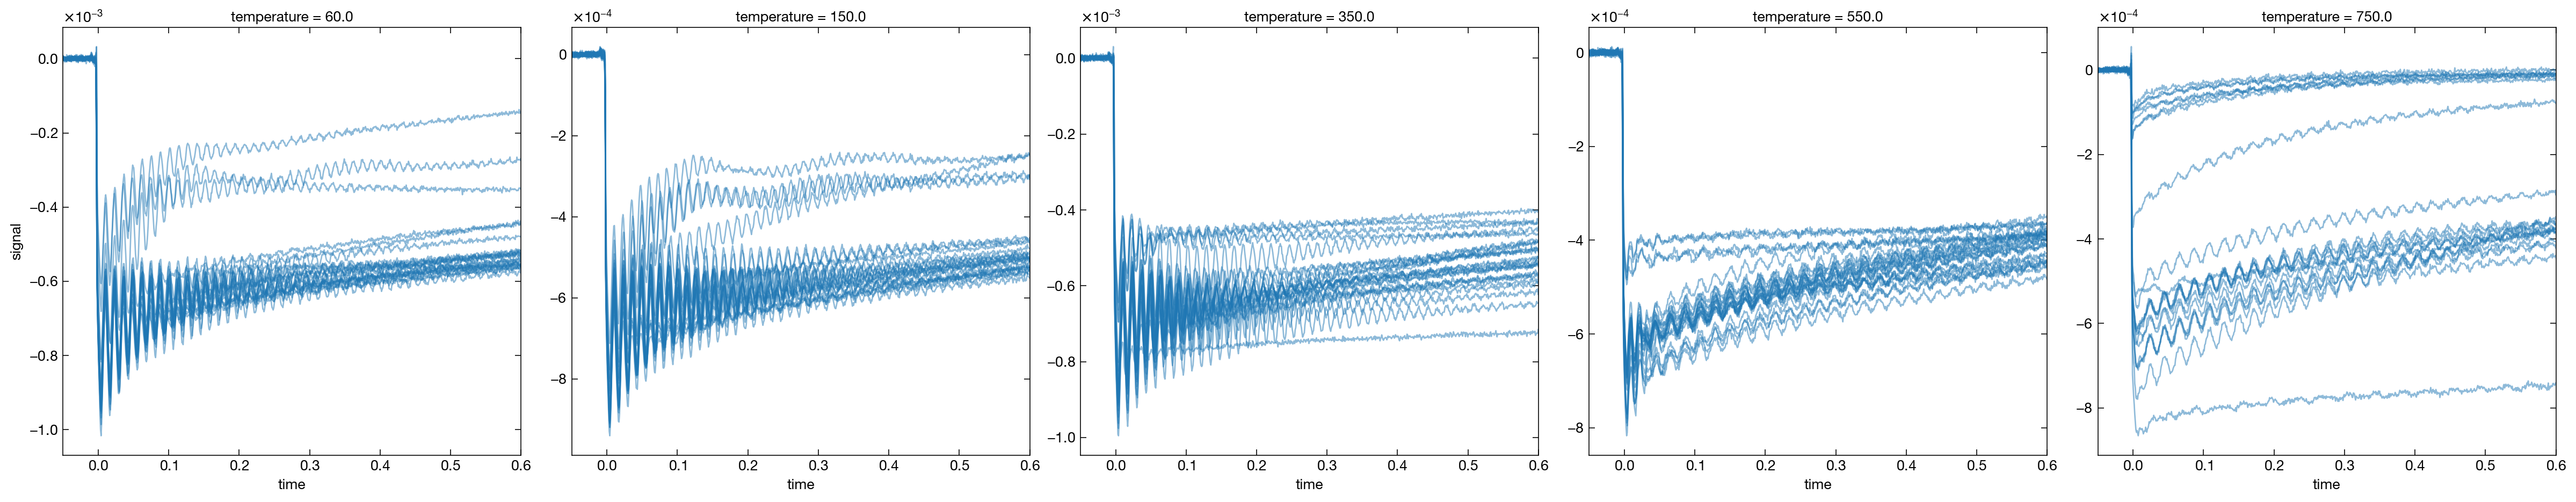

In [3]:
sns.relplot(
    data,
    x="time",
    y="signal",
    col="temperature",
    estimator=None,
    units="filename",
    legend=False,
    kind="line",
    facet_kws={"sharey": False, "despine": False},
    alpha=0.5,
).set(xlim=(-0.05, 0.6))
plt.show()

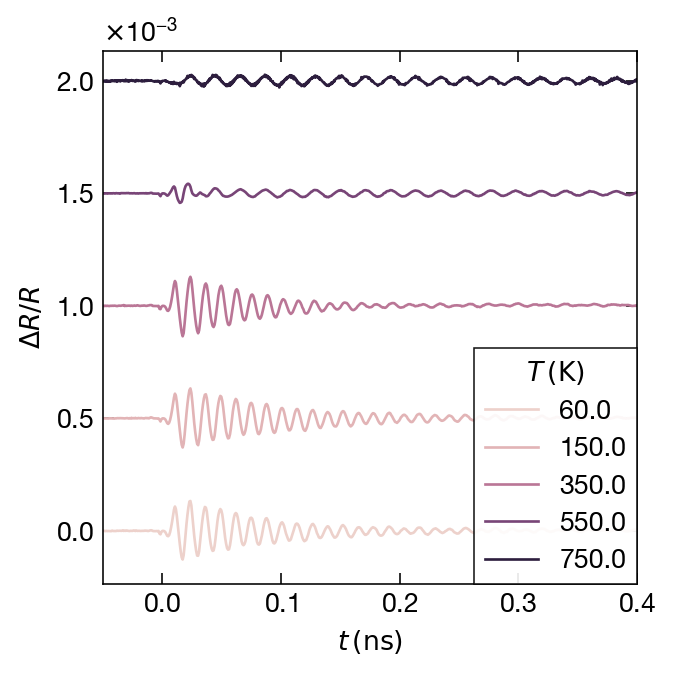

In [4]:
def verify(x):
    not_double = not bool(re.search("double", x))
    not_spotty = not bool(re.search("spotty", x))
    not_translucent = not bool(re.search("translucent", x))
    return not_double and not_spotty and not_translucent


impulse_expr = 1 - np.exp(-(pl.col("time") ** 2) / 1e-4)
data_single = data.filter(pl.col("label").map_elements(verify)).with_columns(
    (pl.col("residual") * impulse_expr).alias("residual")
)

offsets = {
    temperature: 5e-4 * i
    for i, temperature in enumerate(data_single["temperature"].unique())
}
g = sns.lineplot(
    data_single.with_columns(
        pl.col("residual") + pl.col("temperature").replace(offsets)
    ),
    x="time",
    y="residual",
    hue="temperature",
    # estimator=None,
    # units="temperature",
    errorbar=None,
    legend=True,
)
legend = g.legend(
    borderaxespad=0.0,
    title=r"$T\,(\mathrm{K})$",
    bbox_to_anchor=(1, 0),
    loc="lower right",
    edgecolor="0",
)
frame = legend.get_frame()
frame.set_linewidth(0.6)

g.set(xlim=(-0.05, 0.4), xlabel=r"$t\,(\mathrm{ns})$", ylabel=r"$\Delta R/R$")

plt.show()

In [5]:
def pl_fft(df, xname, id_vars=None):
    def varname_iter(fft_dict, value_vars):
        operators = {"real": np.real, "imag": np.imag}
        for name in value_vars:
            for component in ("real", "imag"):
                yield pl.Series(
                    f"{name}.{component}",
                    operators[component](fft_dict[name]),
                )

    def fftfreq(df):
        return np.fft.rfftfreq(
            len(df[xname]),
            abs(df[xname][1] - df[xname][0]),
        )

    value_vars = [var for var in df.columns if var not in id_vars and var != xname]

    frames = []
    if not id_vars:
        fft_dict = {
            name: np.fft.rfft(df[name].to_numpy(zero_copy_only=True))
            for name in value_vars
        }
        frames.append(
            pl.DataFrame(
                (
                    pl.Series("freq", fftfreq(df)),
                    *varname_iter(fft_dict, value_vars),
                )
            )
        )
    else:
        for id_vals, group in df.group_by(*id_vars):
            if isinstance(id_vals, (float, int, str)):
                id_vals = [id_vals]
            fft_dict = {
                name: np.fft.rfft(group[name].to_numpy(zero_copy_only=True))
                for name in value_vars
            }
            frames.append(
                pl.DataFrame(
                    (
                        pl.Series("freq", fftfreq(group)),
                        *varname_iter(fft_dict, value_vars),
                    )
                )
                .with_columns(
                    pl.lit(value).alias(name)
                    for name, value in zip(id_vars, list(id_vals))
                )
                .select(
                    *(pl.col(name) for name in id_vars),
                    "freq",
                    pl.all().exclude("freq", *id_vars),
                )
            )
    return pl.concat(frames)

/Users/monochromatti/miniconda3/envs/scicomp/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


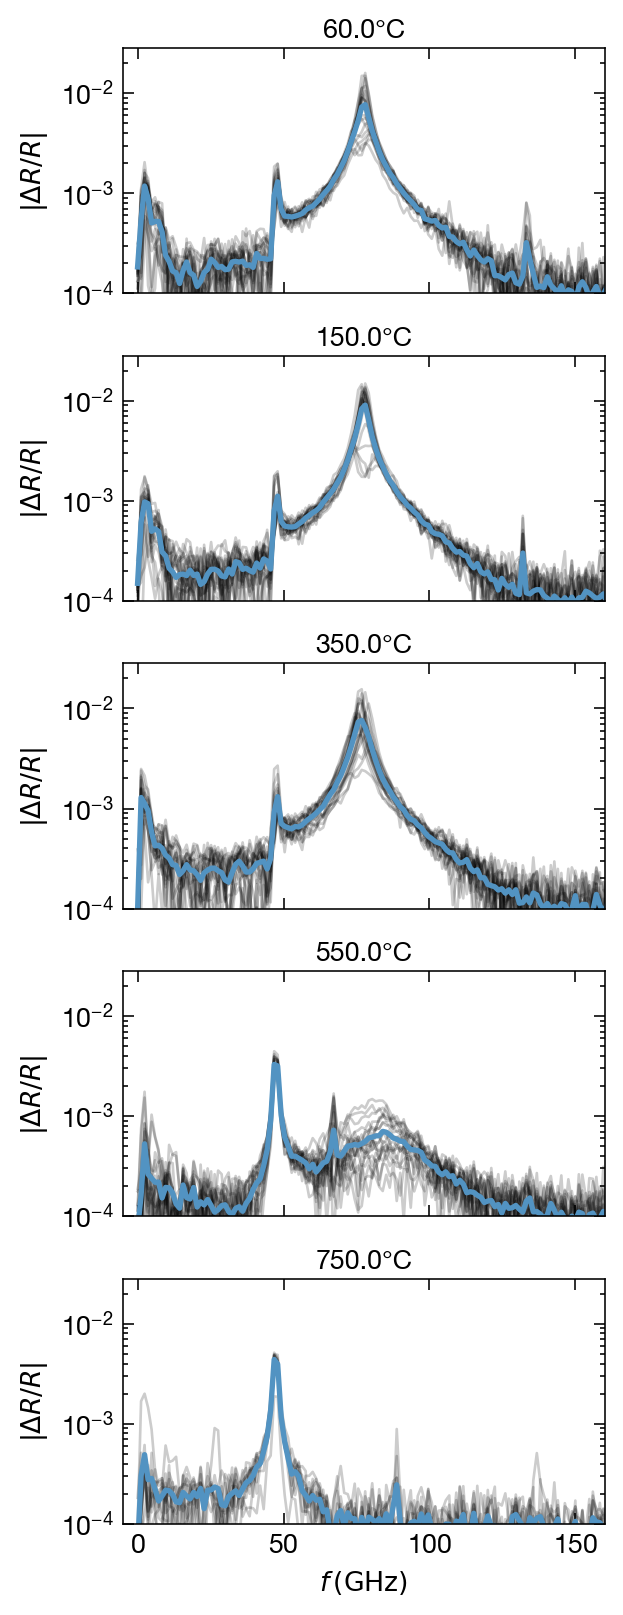

In [6]:
fft_single = (
    data_single.group_by("filename", "label", "temperature")
    .map_groups(
        lambda group: pl_fft(
            group, "time", id_vars=["filename", "label", "temperature"]
        )
    )
    .with_columns(
        (pl.col("residual.real") ** 2 + pl.col("residual.imag") ** 2)
        .sqrt()
        .alias("residual.mag")
    )
)

g = sns.relplot(
    fft_single,
    x="freq",
    y="residual.mag",
    units="filename",
    estimator=None,
    row="temperature",
    kind="line",
    legend=False,
    color="black",
    alpha=0.2,
    height=3.4 / 2,
    aspect=2.0,
    facet_kws=dict(despine=False),
)
g.set(
    yscale="log",
    xticks=np.arange(0, 155, 50),
    xlim=(-5, 160),
    ylim=(1e-4, None),
    ylabel=r"$|\Delta R/R|$",
    xlabel=r"$f\,(\mathrm{GHz})$",
)

mean_data = fft_single.group_by("temperature", "freq").mean()
mean_data = mean_data.select(
    pl.col(s.name) for s in mean_data if not s.is_null().all()
).sort("freq", "temperature")
for ax, (temperature, group) in zip(
    g.axes.flat, mean_data.group_by("temperature", maintain_order=True)
):
    group = group.sort("freq")
    ax.plot(
        group["freq"],
        group["residual.mag"],
        linewidth=2,
        color=(82 / 255, 147 / 255, 194 / 255),
    )

g.set_titles("{row_name}°C")
plt.show()

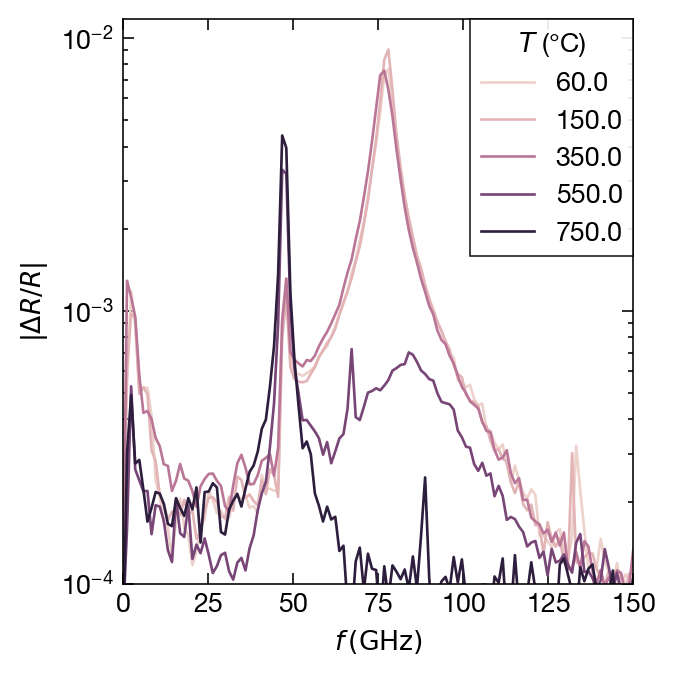

In [7]:
g = sns.lineplot(
    fft_single.group_by("temperature", "freq").mean(),
    x="freq",
    y="residual.mag",
    hue="temperature",
    color="black",
    legend=True,
)
g.set(
    yscale="log",
    xlim=(0, 150),
    ylim=(1e-4, None),
    ylabel=r"$|\Delta R/R|$",
    xlabel=r"$f\,(\mathrm{GHz})$",
)
legend = g.legend(title=r"$T$ (°C)", loc="upper right", borderaxespad=0.0)
legend.get_frame().set(linewidth=0.6)

plt.show()

## Notes

The dynamical Bragg conditons is $ f = 2n v \cos\theta/\lambda$. We use the following parameters:

| Parameter | Value       |
|-----------|-------------|
| $v$       | 7.9 nm/ps   |
| $\lambda$ | 780 nm      |
| $n$       | 2.3460      |
| $\theta$  | $0^\circ$   |

That would give a frequency of

$$
f = \frac{2nv\cos\theta}{\lambda} = \frac{2 \times 2.3460 \times 7.9\,{\rm nm/ps}}{780 \,{\rm nm}} = 47.5\,{\rm GHz}
$$

## Lab notes

### 4 July 2023

The sample was heated to 350 degrees in the furnace. It took about 20 minutes to reach that temperature, and the sample was in the oven for 1 hour and 10 minutes. The stainless steel sample holder changed color from shiny grey to a golden hue.

### Heating curve (furnace)

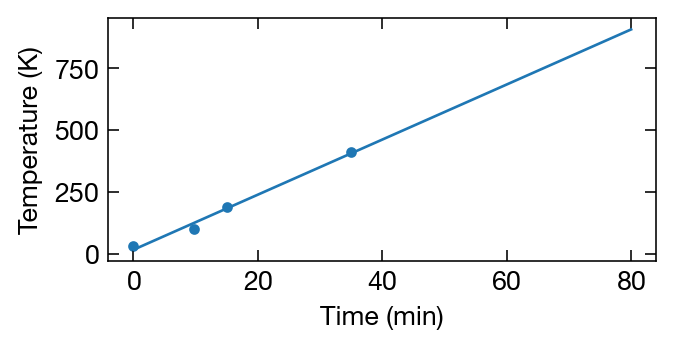

In [8]:
minutes = [0.00, 9.67, 15.00, 35.00]
temperature = [30, 98, 190, 410]

x = np.linspace(0, 80, 1000)

a, b = np.polyfit(minutes, temperature, 1)

fig, ax = plt.subplots(figsize=(3.4, 1.7))
ax.scatter(minutes, temperature)
ax.plot(x, a*x + b)

y0 = 750
x0 = (y0 - b)/a
ax.set(xlabel="Time (min)", ylabel="Temperature (K)")

plt.show()

### Reflectivity calibration

- Reduce amplification 
- Block the light from reference, illuminating only one diode. 
- Rotate the waveplate that sets the incident power before the polarizing beamsplitter (sets relative power of reference and sample beams).
- Record what the lock-in reads from the diode.
- Fit waveplate vs voltage to a squared sine function. The amplitude corresponds to the full power reflected from the sample on diode B.
- During the measurements, A and B are balanced, so the relevant power is $P_B/2$.
- Calculate $\Delta R/R = 2(P_A-P_B)/P_B$.


#### NdNiO3 reflection calibration

939 mV


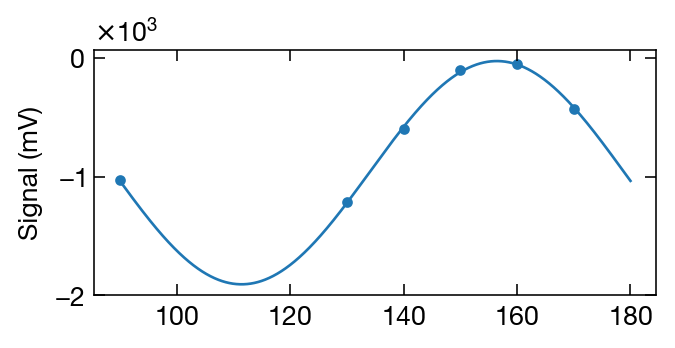

In [9]:
waveplate_angle = (90, 130, 140, 150, 160, 170, )
voltage_rf =      (-1030, -1217, -601, -107, -52, -433)

gain_correction = 1
voltage_rf = np.array(voltage_rf) * gain_correction

def balance_model(angle, amp, offset, yoffset):
    return amp * np.sin(2 * angle * np.pi / 180 - offset)**2 + yoffset
model = lm.Model(balance_model)
params = model.make_params(amp=3000, offset=124, yoffset=0)
res = model.fit(voltage_rf, params, angle=waveplate_angle)

fig, ax = plt.subplots(figsize=(3.4, 1.7))
ax.scatter(waveplate_angle, voltage_rf)
x = np.linspace(90, 180, 1000)
ax.plot(x, res.eval(angle=x))
ax.set(label="HWP pos.", ylabel="Signal (mV)")

print(f"{res.params['amp']/2:.0f} mV")

#### SrRuO<sub>3</sub> reflection calibration (room temperature stamped)

921 mV


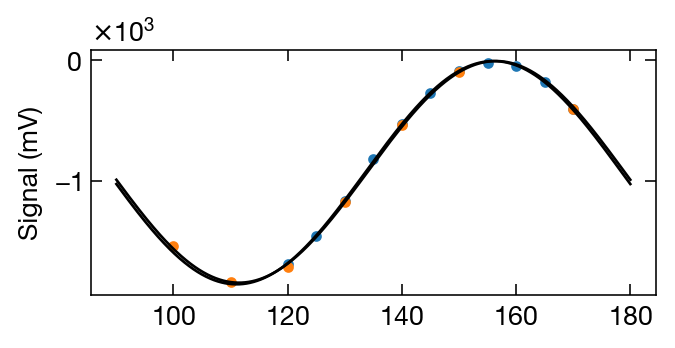

In [10]:
measurements = {}
measurements['flake1'] = {"waveplate_angle": (170, 165, 160, 155, 150, 145, 140, 135, 130, 125, 120),
                            "voltage_rf": (-133, -60, -16, -6, -30, -89, -175, -272, -387, -484, -562)}
measurements['flake2'] = {"waveplate_angle": (100, 110, 120, 130, 140, 150, 170),
                            "voltage_rf": (-512, -612, -569, -391, -179, -31, -135)}

def balance_model(angle, amp, offset, yoffset):
    return amp * np.sin(2 * angle * np.pi / 180 - offset)**2 + yoffset
model = lm.Model(balance_model)
params = model.make_params(amp=3000, offset=124, yoffset=0)

amplitudes = {}

gain_correction = 6/2 # Calibration at 2X, dynamics measurements at 6X 

fig, ax = plt.subplots(figsize=(3.4, 1.7))
x = np.linspace(90, 180, 1000)
for key, value in measurements.items():
    voltage_rf = np.array(value['voltage_rf']) * gain_correction
    waveplate_angle = value['waveplate_angle']

    res = model.fit(voltage_rf, params, angle=waveplate_angle)

    ax.scatter(waveplate_angle, voltage_rf)
    ax.plot(x, res.eval(angle=x), c='k')

    amplitudes[key] = res.params['amp'].value/2

ax.set(label="HWP pos.", ylabel="Signal (mV)")
print(f"{np.mean(list(amplitudes.values())):.0f} mV")

## Simulation

The one-dimensional wave equation for an elastic medium, which models wave propagation such as sound waves or seismic waves, can be written as $\partial_t^2 p = v^2 \partial_x^2 p + s(x, t)$, where:
- $p(x, t)$ is the pressure of the medium at position $x$ and time $t$,
- $v$ is the speed of wave propagation in the medium (for an elastic medium, this is the speed of sound),
- $\partial_t^2 p$ is the second derivative of $u$ with respect to time (representing the acceleration of the medium), and
- $\partial_x^2 p$ is the second derivative of $u$ with respect to position (representing the curvature of the displacement profile).
- $s(x, t)$ is a source term.

This equation states that the acceleration of the medium at any point is proportional to the curvature of the displacement profile at that point, with the constant of proportionality being the square of the wave speed. It is a second-order linear partial differential equation, and solutions to this equation represent waves traveling in both the positive and negative $x$ directions.


The second-order wave equation can be discretized using finite difference methods. This results in a discrete set of equations that can be solved numerically. Using a standard central difference scheme for both time and space, the discrete form of the one-dimensional wave equation is:
$$
    \frac{p^{n+1}_i - 2p^n_i + p^{n-1}_i}{\Delta t^2} = v^2 \frac{p^n_{i+1} - 2p^n_i + p^n_{i-1}}{\Delta x^2} + s_i^n
$$

This equation can be rearranged to give an explicit method for updating the solution in time:
$$
    p^{n+1}_i = 2p^n_i - p^{n-1}_i +  c^2 (p^n_{i+1} - 2p^n_i + p^n_{i-1}) + s_i^n
$$
Here we have defined the Courant number,
$$
    c = v \frac{\Delta t}{\Delta x}
$$
which also must be less than 1 for the solver to be stable.

In [11]:
# def update_interior(p1, p2, source, k, i, idxint):
#     try:
#         with warnings.catch_warnings():
#             warnings.simplefilter("error")
#             p1[i + 1, 1:idxint] = (
#                 2 * p1[i, 1:idxint]
#                 - p1[i - 1, 1:idxint]
#                 + c1**2
#                 * (p1[i, 2 : idxint + 1] - 2 * p1[i, 1:idxint] + p1[i, 0 : idxint - 1])
#                 + source[i + 1, 1:idxint]
#             )
#             p2[i + 1, idxint:-1] = (
#                 2 * p2[i, idxint:-1]
#                 - p2[i - 1, idxint:-1]
#                 + c2**2
#                 * (p2[i, idxint + 1 :] - 2 * p2[i, idxint:-1] + p2[i, idxint - 1 : -2])
#                 + source[i + 1, idxint:-1]
#             )
#             p1[i + 1, idxint] += (
#                 k * (p2[i, idxint] - p1[i, idxint])
#                 + p1[i, idxint - 1]
#                 + source[i + 1, idxint]
#             )
#             p2[i + 1, idxint] += (
#                 k * (p1[i, idxint] - p2[i, idxint])
#                 + p2[i, idxint - 1]
#                 + source[i + 1, idxint]
#             )

#     except RuntimeWarning:
#         print(f"Overflow encountered at time step {i}. Terminating simulation.")
#         return p1, p2, True  # Return a flag indicating that an overflow occurred
#     return p1, p2, False


# def update_boundaries(p1, p2):
#     p1[
#         i + 1, 0
#     ] = 0  # Rigid boundary. Assumes vibration does not generate sound waves in air.
#     p2[i + 1, -1] = (
#         -c2 * (p2[i, -1] - p2[i, -2]) + p2[i, -1]
#     )  # Radiating boundary. Mimics infinite substrate.
#     return p1, p2


# # Domain size and physical variables
# L_film = 34  # size of domain [nm]
# L_sub = 50  # size of substrate [nm]
# L = L_film + L_sub  # size of simulation domain [nm]
# T = 10  # total time to simulate [ps]
# v1 = 5.4  # speed of sound in thin solid [ps/nm]
# v2 = 10.4  # speed of sound in infinite solid [ps/nm]
# k = 0.7

# # Discretization parameters
# dx = 4e-3
# dt = 2e-4

# c1 = v1 * dt / dx  # Courant number, thin solid
# c2 = v2 * dt / dx  # Courant number, infinite solid

# print(f"c1 = {c1:.2f}, c2 = {c2:.2f}")

# if max(v1, v2) * dt / dx >= 1:
#     raise ValueError("Stability condition not satisfied.")

# # Define the grid in space
# x = np.arange(0, L, dx)
# t = np.arange(0, T, dt)
# idxint = floor(x.size * L_film / L)  # Index of `x` at interface

# t_pump = 5
# source = np.zeros((t.size, x.size))
# for i in range(0, idxint):
#     # Step function:
#     # source[:, i] = 1e-4 * (1 + np.tanh((t - t_pump)/0.1)) / 2

#     # # Gaussian pulse:
#     source[:, i] += 0.01 * np.exp(-((t - t_pump) ** 2) / 0.1**2)

# p1 = np.zeros((t.size, x.size))  # displacement field in thin solid
# p2 = np.zeros((t.size, x.size))  # displacement field in infinite solid

# for i in range(1, t.size - 1):
#     # Update interior points
#     p1, p2, flag = update_interior(p1, p2, source, k, i, idxint)
#     if flag:
#         break
#     else:
#         p1, p2 = update_boundaries(p1, p2)

In [12]:
# fig = plt.figure(figsize=(6.8, 6.8))
# gs = fig.add_gridspec(2, 1, wspace=.5, height_ratios=(6.8, 1))
# ax = [fig.add_subplot(gs[0], projection="3d"), fig.add_subplot(gs[1])]

# ax[1].plot(t, p1[:, floor(idxint / 2)], label=f"k={k}", lw=0.5)

# ax[0].set(xlabel="Position (nm)", ylabel="Time (ps)")
# ax[1].set(xlabel="Time (ps)", ylabel=r"$p$")

# X, T = np.meshgrid(x, t)
# U = (p1 + p2).reshape((t.size, x.size))

# plot_kwargs = dict(rstride=10, cstride=10, cmap=sns.color_palette("coolwarm", as_cmap=True), linewidth=0, shade=False)

# # time_idx = slice(0, t.size, 10)
# # pos_idx = slice(0, None, 10)
# # ax[0].plot_surface(X[time_idx, pos_idx], T[time_idx, pos_idx], U[time_idx, pos_idx], **plot_kwargs)
# # ax[0].view_init(elev=30, azim=-45, roll=0)

# plt.show()